In [81]:
using Plots
using Statistics
using Flux
using Random
using Gen
using Distributions
using StatsFuns

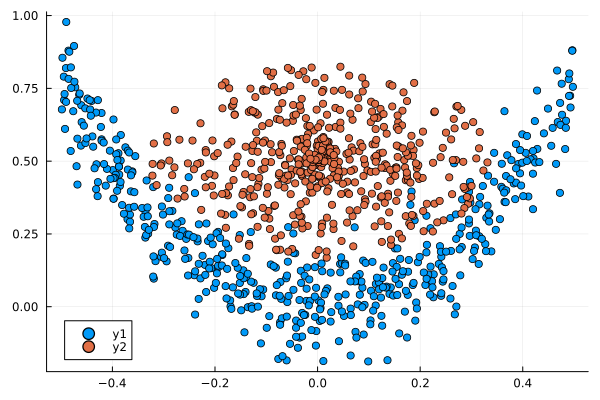

In [82]:
#Auxiliary functions for generating our data
function generate_real_data(n)
    x1 = rand(1,n) .- 0.5
    x2 = (x1 .* x1)*3 .+ randn(1,n)*0.1
    return vcat(x1,x2)
end
function generate_fake_data(n)
    θ  = 2*π*rand(1,n)
    r  = rand(1,n)/3
    x1 = @. r*cos(θ)
    x2 = @. r*sin(θ)+0.5
    return vcat(x1,x2)
end
# Creating our data
train_size = 5000
real = generate_real_data(train_size)
fake = generate_fake_data(train_size)
# Visualizing
scatter(real[1,1:500],real[2,1:500])
scatter!(fake[1,1:500],fake[2,1:500])

In [87]:
# Organizing the data in batches
X    = hcat(real,fake)
y    = vcat(ones(train_size),zeros(train_size))
data = Flux.Data.DataLoader((X, Y'), batchsize=100,shuffle=true);

loss (generic function with 1 method)

In [18]:
function split(X, y::AbstractVector; dims=1, ratio_train=0.8)
    n = length(y)
    size(X, dims) == n || throw(DimensionMismatch("..."))

    n_train = round(Int, ratio_train*n)
    i_rand = randperm(n)
    i_train = i_rand[1:n_train]
    i_test = i_rand[n_train+1:end]

    return selectdim(X, dims, i_train), y[i_train], selectdim(X, dims, i_test), y[i_test]
end

split (generic function with 1 method)

In [29]:
X_train, y_train, X_test, y_test = split(X', y)

([0.46080241777647624 0.6079409627313964; 0.20439031651072603 0.10855657543413524; … ; -0.3836859770578016 0.5350037611448608; -0.004702433160470323 0.4623264597260796], [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0], [-0.2842438366647453 0.3197309206632396; -0.07420001408665747 0.4331545595792998; … ; -0.07887342736747216 -0.018466964344619887; 0.49983942413743965 0.7883020596693253], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0  …  0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0])

In [43]:
X_test = X_test'
X_train = X_train'

2×8000 adjoint(view(adjoint(::Matrix{Float64}), [3936, 3955, 6670, 2634, 2090, 7745, 7690, 641, 2621, 8537  …  3721, 3139, 1118, 3750, 5103, 1424, 6595, 2017, 2983, 6422], :)) with eltype Float64:
 0.460802  0.20439   0.117686  …  -0.182635   -0.383686  -0.00470243
 0.607941  0.108557  0.802202     -0.0185922   0.535004   0.462326

In [41]:
#network for binary classification:
nn_initial = Chain(
        Dense(2, 25,relu),
        Dense(25,1),
        sigmoid
        )

Chain(
  Dense(2 => 25, relu),                 # 75 parameters
  Dense(25 => 1),                       # 26 parameters
  NNlib.σ,
)                   # Total: 4 arrays, 101 parameters, 660 bytes.

In [42]:
parameters_initial, reconstruct = Flux.destructure(nn_initial)
nb_param = length(parameters_initial) # number of paraemters in NN

101

In [52]:
@gen function test(nn, input)
    prob = nn(input)[1]
    obs_test = {:obs_test} ~ bernoulli(prob)
    print(obs_test)
    return obs_test
end
test(nn_initial,X_train[:,1])

false

false

In [53]:
#binary classification:
@gen function bayes_nn(xs, nparameters, reconstruct)
    # Create the weight and bias vector.
    parameters = Float32[]
    for i=1:nparameters
        push!(parameters, {(:parameters, i)} ~ normal(0,1))
    end

    # Construct NN from parameters
    nn = reconstruct(parameters)
    # Forward NN to make predictions
    # Observe each prediction.
    obs = Bool[]
    for i=1:size(xs)[2]
        #probs = convert(Vector{Float64}, nn(xs[:,i]))
        prob = nn(xs[:,i])[1]
        observation = {(:obs, i)} ~ bernoulli(prob)
        push!(obs, observation)
    end
    obs
end;

In [55]:
#y_train[2]!!!!!!!!!!!!!!CONVERT TO BOOL???????????????????????

1.0

In [60]:
function make_constraints()
    constraints = Gen.choicemap()
    for i=1:size(X_train)[2]
        constraints[(:obs, i)] = Bool(y_train[i])
    end
    constraints
end

function get_params_from_trace(trace, nb_params)
    params = Float32[]
    for i=1:nb_params
        push!(params, trace[(:parameters,i)])
    end
    return params
end

observations = make_constraints();

In [103]:
function block_resimulation_update(tr)
    for i=1:tr.args[2]
        latent_variable = Gen.select((:parameters,i))
        (tr, _) = mh(tr, latent_variable)
    end
    tr
end

function block_resimulation_inference(tr, n_samples)
    trs = []
    for iter=1:n_samples
        tr = block_resimulation_update(tr)
        trace_params = get_params_from_trace(tr, nb_param)
        current_nn = tr.args[3](trace_params)
        y_hat_pred = Bool[]
        for i = 1:size(X_test)[2]
            push!(y_hat_pred, argmax(current_nn(X_test[:,i])))
        end

        
        println("Iteration: $(iter), Accuracy: $(mean(current_nn(real)))")
        push!(trs, tr)
    end
    
    trs
end;

In [104]:
(trace, _) = Gen.generate(bayes_nn, (X_train, nb_param, reconstruct), observations);
trs = block_resimulation_inference(trace, 10)

Iteration: 1, Accuracy: 0.6308809149971834
Iteration: 2, Accuracy: 0.7132524422978529
Iteration: 3, Accuracy: 0.779281741314626
Iteration: 4, Accuracy: 0.8032435229456198
Iteration: 5, Accuracy: 0.821948955030915
Iteration: 6, Accuracy: 0.8263547027024218
Iteration: 7, Accuracy: 0.827396009630096
Iteration: 8, Accuracy: 0.8561855090424553
Iteration: 9, Accuracy: 0.8480388559758374
Iteration: 10, Accuracy: 0.8639680546445088


10-element Vector{Any}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##bayes_nn#320", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:obs, 1409) => Gen.ChoiceOrCallRecord{Bool}(true, -0.7943500788950661, NaN, true), (:obs, 2627) => Gen.ChoiceOrCallRecord{Bool}(false, -0.3053772982791539, NaN, true), (:obs, 519) => Gen.ChoiceOrCallRecord{Bool}(true, -0.27530090762740045, NaN, true), (:obs, 2178) => Gen.ChoiceOrCallRecord{Bool}(true, -0.18040827493808237, NaN, true), (:obs, 2810) => Gen.ChoiceOrCallRecord{Bool}(true, -0.2699551187814807, NaN, true), (:obs, 7186) => Gen.ChoiceOrCallRecord{Bool}(false, -0.6392195848339451, NaN, true), (:obs, 1520) => Gen.ChoiceOrCallRecord{Bool}(false, -0.8383960543758269, NaN, true), (:obs, 5301) => Gen.ChoiceOrCallRecord{Bool}(false, -0.7039548964499869, NaN, 

In [110]:
function NeuralNetwork()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1,x->σ.(x))
            )
end
# Defining our model, optimization algorithm and loss function
m    = NeuralNetwork()
opt = Descent(0.05)
loss(x, y) = sum(Flux.Losses.binarycrossentropy(m(x), y))
ps = Flux.params(m)

Params([Float32[-0.064015165 -0.11904765; -0.39528006 0.23935594; … ; 0.44016948 -0.41913214; -0.16365261 0.22747655], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.016266147 0.36310694 … -0.43539286 -0.2717887], Float32[0.0]])

In [111]:
epochs = 10
for i in 1:epochs
    Flux.train!(loss, ps, data, opt)
    println("Iteration $i,  Accuracy: $(mean(m(real))))")
end

Iteration 1,  Accuracy: 0.5194123911848135)
Iteration 2,  Accuracy: 0.5587943990085229)
Iteration 3,  Accuracy: 0.5996471393902391)
Iteration 4,  Accuracy: 0.6124666570004751)
Iteration 5,  Accuracy: 0.6365375882389933)
Iteration 6,  Accuracy: 0.6518046770604405)
Iteration 7,  Accuracy: 0.6716269212784952)
Iteration 8,  Accuracy: 0.6854994696269556)
Iteration 9,  Accuracy: 0.6999079280518236)
Iteration 10,  Accuracy: 0.7060025045147237)
